In [27]:
# Spezieller Befehl zum Einrichten der Plots (kein Python) 
# Unbedingt ausfuehren damit die Plots funktionieren!
%matplotlib notebook 

## The Mitchell Schaefer Model

* A simple Model for cardiac dynamics, limiting only to (normalized) membrane Potential and one modeling refractoriness.

##### Things to take away:

1. Function definition
2. Integration with `scipy.integrate`
3. Simple plotting with `matplotlib.pyplot`

In [24]:
import numpy as np


def mitchell_schaefer(y, time, a=0.03, tau_in=0.3, tau_out=6,
                      tau_open=120, tau_close=150, v_gate=0.13):
    """
    The Mitchell Schäfer Model [1]
    
    Parameters
    ----------
    y : [v, h]
        Die Variablen des Modells v "Membranspannung" und h.
    time : float
        Die Zeit (wird nicht verwendet)
    a : float
        Parameter der das Oszillieren bestimmt. Keine Oszillation bei 0.
    tau_in : float
        Bestimmt den Upstroke.
    tau_out : float
        Bestimmt den Downstroke
    tau_open : float
        Zeitkonstante wenn ``v < v_gate``
    tau_close : float
        Zeitkonstante wenn ``v >= v_gate``
    v_gate : float
        Gating Spannung fuer h.
    
    [1] "A Two-Current Model for the Dynamics of Cardiac Membrane" Bulletin of Mathematical Biology, 2003
    """
    v = y[0]
    h = y[1]
    dv = (h * (v + a)**2 * (1 - v))/tau_in - v/tau_out
    if v >= v_gate:
        dh = -h/tau_close
    else:
        dh = (1-h)/tau_open

    return np.array([dv, dh])



In [28]:
# Integrieren mit Hilfe von SciPy:

from scipy.integrate import odeint

times = np.linspace(0, 2000, 2001)
y = odeint(mitchell_schaefer, np.array([0., 0.]), times)

<IPython.core.display.Javascript object>


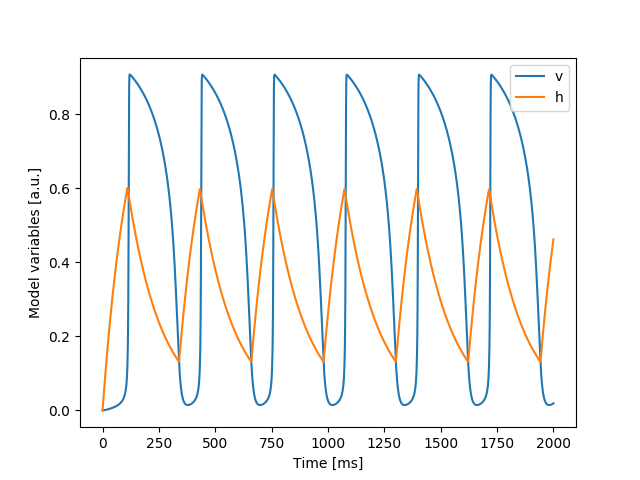

In [29]:
from matplotlib import pyplot as plt

v = y[:, 0]
h = y[:, 1]

figure = plt.figure()
plt.plot(times, v, label='v')
plt.plot(times, h, label='h')
plt.legend()
plt.xlabel('Time [ms]')
plt.ylabel('Model variables [a.u.]')

<IPython.core.display.Javascript object>


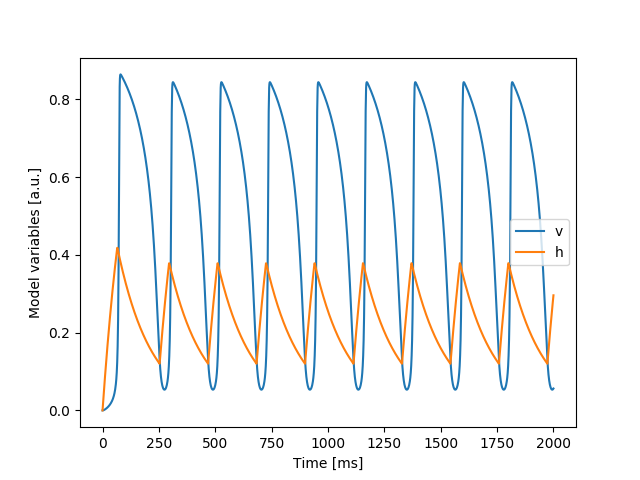

In [34]:
# Mit Grösserer Frequenz (größerem Parameter a):

y = odeint(lambda y, t: mitchell_schaefer(y, t, a=0.05), np.array([0., 0.]), times)

v = y[:, 0]
h = y[:, 1]

figure = plt.figure()
plt.plot(times, v, label='v')
plt.plot(times, h, label='h')
plt.legend()
plt.xlabel('Time [ms]')
plt.ylabel('Model variables [a.u.]')

### Same example in two dimension

This example shows some more advanced NumPy:

In [35]:
def mitchell_schaefer_arr(y, a=0.03, tau_in=0.3, tau_out=6,
                          tau_open=120, tau_close=150, v_gate=0.13):
    """
    Calculate Mitchell Scahefer, y is an array with with
    v = y[0] and h = y[1]. No time necessary, since it is not part of the
    equations.
    """
    v = y[0]
    h = y[1]
    
    derivative = np.empty_like(y)
    dv = derivative[0]
    dh = derivative[1]
    
    dv[...] = (h * (v + a)**2 * (1 - v))/tau_in - v/tau_out
    
    # Boolean arrays can be used for indexing (see below)
    v_above = (v >= v_gate)
    v_below = np.logical_not(v_above)
    
    # Calculate derivative only for those above v_gate:
    dh[v_above] = -h[v_above]/tau_close
    # Calculate derivative only for those below v_gate:
    dh[v_below] = (1-h[v_below])/tau_open

    return derivative



## Modelling Cardiac Wave Spreading

* Typical model for wave spreading is the diffusion of membrane Potential
* Diffusion is a Laplace-Operator
* A convolution can be used to calculate it:

In [39]:
from scipy.ndimage import convolve


def laplace_operator(v, D=.1, dx=1):
    # Define the diffusion kernel:
    kernel = np.array([[1.,   4., 1.],
                       [4., -20., 4.],
                       [1.,   4., 1.]])
    kernel = kernel / (6. * dx**2)
    kernel = D * kernel
    
    # Use a convolution to model the diffusion:
    return convolve(v, kernel, mode='reflect')

#### Both functions together model a single time step:

In [43]:
def time_step(y, dT):
    """
    Update the state `y` using an Euler-Step of length `dT` 
    """
    # Calculate the local derivative:
    derivative_local = mitchell_schaefer_arr(y, a=0)
    # And the derivative due to the Laplace Operator:
    derivative_diffusion = laplace_operator(y[0])
    
    # And do the time step (local part):
    y += dT * derivative_local
    # As well as the diffusive part (which only uses ``y[0]``):
    y[0] += dT * derivative_diffusion
    
    # The function does not return anything, because y is
    # changed!

In [44]:

# Define starting values:
y = np.zeros((2, 100, 100))
v = y[0, ...]
h = y[1, ...]

v[:80, :] = 0.8
h[:, :50] = 0.8

times = []
result_v = []

dT = 0.2

for step in range(15000):
    time_step(y, dT)
    
    # Ab und zu das Ergebnis speichern
    if step % 50 == 0:
        print('Simulated up until time={}'.format(step * dT))
        # Note the copy, since numpy is in-place!:
        times.append(step * dT)
        result_v.append(v.copy())
    
# In ein Array umwandeln (nicht unbedingt nötig)
times = np.asarray(times)
result_v = np.asarray(result_v)

Simulated up until time=0.0
Simulated up until time=10.0
Simulated up until time=20.0
Simulated up until time=30.0
Simulated up until time=40.0
Simulated up until time=50.0
Simulated up until time=60.0
Simulated up until time=70.0
Simulated up until time=80.0
Simulated up until time=90.0
Simulated up until time=100.0
Simulated up until time=110.0
Simulated up until time=120.0
Simulated up until time=130.0
Simulated up until time=140.0
Simulated up until time=150.0
Simulated up until time=160.0
Simulated up until time=170.0
Simulated up until time=180.0
Simulated up until time=190.0
Simulated up until time=200.0
Simulated up until time=210.0
Simulated up until time=220.0
Simulated up until time=230.0
Simulated up until time=240.0
Simulated up until time=250.0
Simulated up until time=260.0
Simulated up until time=270.0
Simulated up until time=280.0
Simulated up until time=290.0
Simulated up until time=300.0
Simulated up until time=310.0
Simulated up until time=320.0
Simulated up until ti

Simulated up until time=2710.0
Simulated up until time=2720.0
Simulated up until time=2730.0
Simulated up until time=2740.0
Simulated up until time=2750.0
Simulated up until time=2760.0
Simulated up until time=2770.0
Simulated up until time=2780.0
Simulated up until time=2790.0
Simulated up until time=2800.0
Simulated up until time=2810.0
Simulated up until time=2820.0
Simulated up until time=2830.0
Simulated up until time=2840.0
Simulated up until time=2850.0
Simulated up until time=2860.0
Simulated up until time=2870.0
Simulated up until time=2880.0
Simulated up until time=2890.0
Simulated up until time=2900.0
Simulated up until time=2910.0
Simulated up until time=2920.0
Simulated up until time=2930.0
Simulated up until time=2940.0
Simulated up until time=2950.0
Simulated up until time=2960.0
Simulated up until time=2970.0
Simulated up until time=2980.0
Simulated up until time=2990.0


<IPython.core.display.Javascript object>


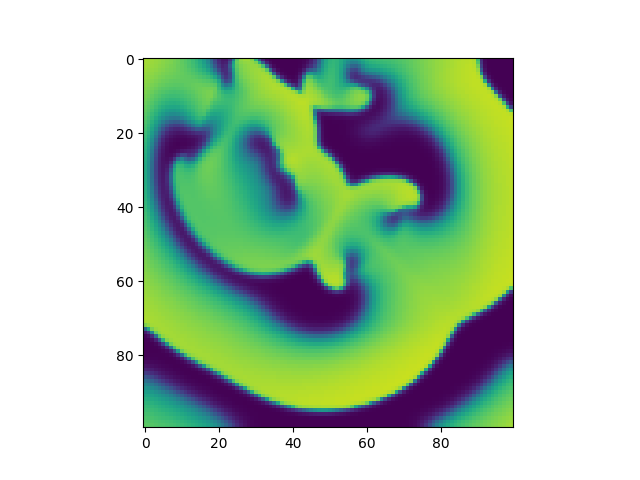

In [45]:
# Und das Resulat angucken!:

from matplotlib.animation import FuncAnimation

figure = plt.figure()
image = plt.imshow(result_v[0], interpolation='nearest',
                   vmin=0, vmax=1)

def update_v(frame):
    # Veraendert die Daten die im Bild angezeigt werden. Details bei matplotlib:
    # https://matplotlib.org/gallery/animation/dynamic_image.html#sphx-glr-gallery-animation-dynamic-image-py
    image.set_array(result_v[frame])


anim = FuncAnimation(figure, update_v, len(result_v), interval=50, repeat=False)

plt.show()
